In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as tf
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Weather/san-francisco.csv')
dfi

,DATE,WND_DEG,WND_SPEED[m/s],VIS[m],TMP[C],DEW[C],AP[hPa],CIG[m]
0,2024-01-01 00:00:00,20.0,2.1,16093.0,13.3,10.2,1018.6,2286.0
1,2023-12-31 23:00:00,30.0,2.1,16093.0,13.9,9.4,1018.6,2286.0
2,2023-12-31 22:00:00,NaN,1.5,16093.0,13.3,9.4,1018.6,1006.0
3,2023-12-31 21:00:00,50.0,2.6,16046.5,13.9,10.6,1019.0,4572.0
4,2023-12-31 20:00:00,80.0,3.1,16093.0,12.8,10.6,1019.6,4267.0
...,...,...,...,...,...,...,...,...
446006,1973-01-01 04:00:00,340.0,3.6,24000.0,10.0,-2.0,1024.7,22000.0
446007,1973-01-01 03:00:00,NaN,6.2,24000.0,10.6,-0.6,1023.7,22000.0
446008,1973-01-01 02:00:00,NaN,6.1,24000.0,13.0,-2.0,1023.7,22000.0
446009,1973-01-01 01:00:00,340.0,6.7,70000.0,12.0,-1.0,1023.7,22000.0


In [3]:
df = dfi.loc[dfi['DATE'] > '2023-06-01']
df

,DATE,WND_DEG,WND_SPEED[m/s],VIS[m],TMP[C],DEW[C],AP[hPa],CIG[m]
0,2024-01-01 00:00:00,20.0,2.10,16093.0,13.3,10.20,1018.6,2286.0
1,2023-12-31 23:00:00,30.0,2.10,16093.0,13.9,9.40,1018.6,2286.0
2,2023-12-31 22:00:00,NaN,1.50,16093.0,13.3,9.40,1018.6,1006.0
3,2023-12-31 21:00:00,50.0,2.60,16046.5,13.9,10.60,1019.0,4572.0
4,2023-12-31 20:00:00,80.0,3.10,16093.0,12.8,10.60,1019.6,4267.0
...,...,...,...,...,...,...,...,...
5132,2023-06-01 04:00:00,250.0,5.70,16093.0,13.3,8.90,1011.7,11244.0
5133,2023-06-01 03:00:00,245.0,7.45,16093.0,13.9,8.90,1011.5,22000.0
5134,2023-06-01 02:00:00,260.0,7.20,16093.0,15.0,9.40,1011.5,488.0
5135,2023-06-01 01:00:00,250.0,8.75,16093.0,15.0,9.15,1011.5,11274.5


In [4]:
df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'
, 'TMP[C]': 'tempm', 'DEW[C]': 'dewptm', 'AP[hPa]':'press','CIG[m]':'ceil'}, inplace=True)
df = df[['wind_sp','tempm','press','dewptm']]
df = df.dropna()
df = df.reset_index(drop=True)
df

/tmp/ipykernel_41874/932233946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'


,wind_sp,tempm,press,dewptm
0,2.10,13.3,1018.6,10.20
1,2.10,13.9,1018.6,9.40
2,1.50,13.3,1018.6,9.40
3,2.60,13.9,1019.0,10.60
4,3.10,12.8,1019.6,10.60
...,...,...,...,...
5130,5.70,13.3,1011.7,8.90
5131,7.45,13.9,1011.5,8.90
5132,7.20,15.0,1011.5,9.40
5133,8.75,15.0,1011.5,9.15


In [5]:
df['nxt_target'] = df['dewptm'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5135 entries, 0 to 5134
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wind_sp     5135 non-null   float64
 1   tempm       5135 non-null   float64
 2   press       5135 non-null   float64
 3   dewptm      5135 non-null   float64
 4   nxt_target  5135 non-null   float64
dtypes: float64(5)
memory usage: 200.7 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,wind_sp,tempm,press,dewptm,nxt_target
0,2.1,13.3,1018.6,10.2,9.4
1,2.1,13.9,1018.6,9.4,9.4
2,1.5,13.3,1018.6,9.4,10.6
3,2.6,13.9,1019.0,10.6,10.6
4,3.1,12.8,1019.6,10.6,10.0
...,...,...,...,...,...
4103,8.8,21.7,1014.6,12.2,12.2
4104,8.8,21.1,1014.9,12.2,12.2
4105,6.7,22.2,1015.2,12.2,11.7
4106,7.7,21.1,1015.9,11.7,11.7


In [8]:
train.iloc[:,-1:]

,nxt_target
0,9.4
1,9.4
2,10.6
3,10.6
4,10.0
...,...
4103,12.2
4104,12.2
4105,11.7
4106,11.7


In [9]:
train.iloc[:,:4]

,wind_sp,tempm,press,dewptm
0,2.1,13.3,1018.6,10.2
1,2.1,13.9,1018.6,9.4
2,1.5,13.3,1018.6,9.4
3,2.6,13.9,1019.0,10.6
4,3.1,12.8,1019.6,10.6
...,...,...,...,...
4103,8.8,21.7,1014.6,12.2
4104,8.8,21.1,1014.9,12.2
4105,6.7,22.2,1015.2,12.2
4106,7.7,21.1,1015.9,11.7


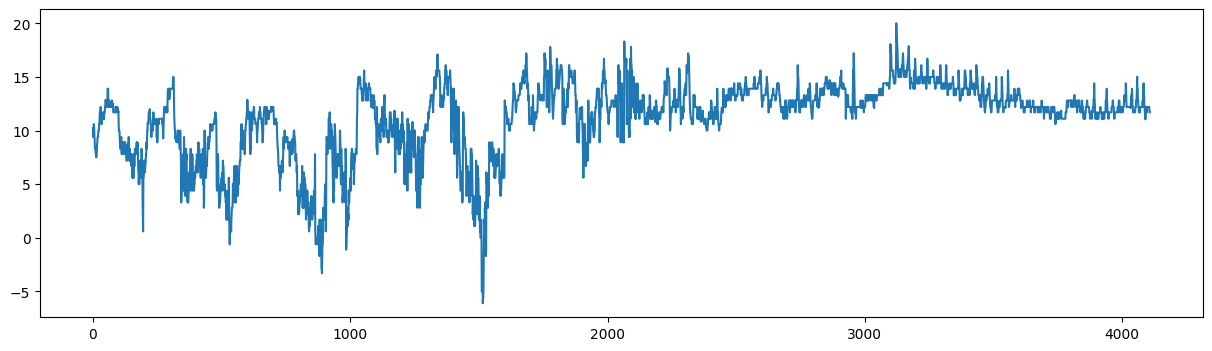

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["dewptm"])
plt.show()

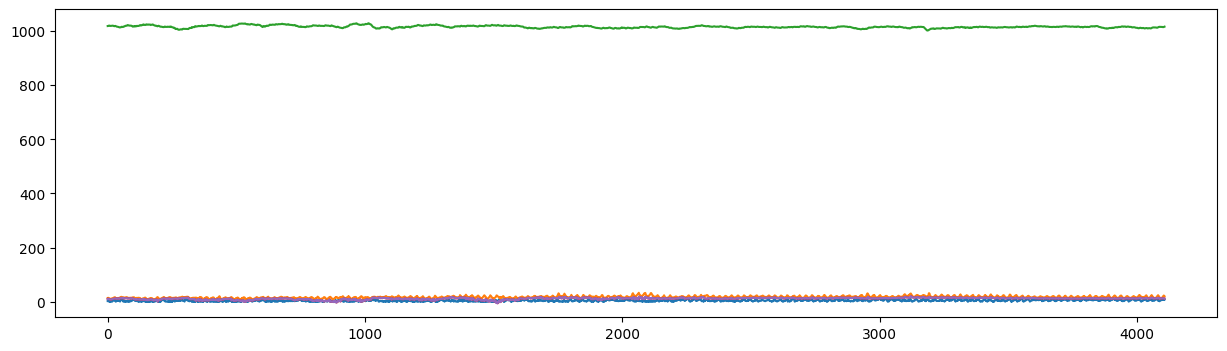

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
batch_size, seq_length, features_size =X_train.size()
print(batch_size)
X_train[0][0]

torch.Size([4098, 10, 4])
4098


tensor([-0.6867, -0.9489,  0.6450, -0.2746])

In [17]:
device = "cpu"

In [18]:
def init_hidden(x: torch.Tensor, hidden_size: int, num_dir: int = 1, xavier: bool = True):
    
    if xavier:
        return nn.init.xavier_normal_(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)
    return Variable(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)

In [19]:
class AttnEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=1
        )
        self.attn = nn.Linear(
            in_features=2 * self.hidden_size + self.seq_len,
            out_features=1
        )
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, input_data: torch.Tensor):
        
        h_t, c_t = (init_hidden(input_data, self.hidden_size),
                    init_hidden(input_data, self.hidden_size))

        attentions, input_encoded = (Variable(torch.zeros(input_data.size(0), self.seq_len, self.input_size)),
                                     Variable(torch.zeros(input_data.size(0), self.seq_len, self.hidden_size)))

        
        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1).to(device)), dim=2).to(
                device)  # bs * input_size * (2 * hidden_dim + seq_len)

            e_t = self.attn(x.view(-1, self.hidden_size * 2 + self.seq_len))  # (bs * input_size) * 1
            a_t = self.softmax(e_t.view(-1, self.input_size)).to(device)  # (bs, input_size)

            weighted_input = torch.mul(a_t, input_data[:, t, :].to(device))  # (bs * input_size)
            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(weighted_input.unsqueeze(0), (h_t, c_t))

            input_encoded[:, t, :] = h_t
            attentions[:, t, :] = a_t

        return attentions, input_encoded

In [20]:
class AttnDecoder(nn.Module):
    def __init__(self,  hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnDecoder, self).__init__()
        self.seq_len = seq_len
        self.encoder_hidden_size = hidden_size
        self.decoder_hidden_size = hidden_size
        self.out_feats = 1

        self.attn = nn.Sequential(
            nn.Linear(2 * self.decoder_hidden_size + self.encoder_hidden_size, self.encoder_hidden_size),
            nn.Tanh(),
            nn.Linear(self.encoder_hidden_size, 1)
        )
        self.lstm = nn.LSTM(input_size=self.out_feats, hidden_size=self.decoder_hidden_size)
        self.fc = nn.Linear(self.encoder_hidden_size + self.out_feats, self.out_feats)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size, self.out_feats)
        self.fc.weight.data.normal_()

    def forward(self, input_encoded: torch.Tensor, y_history: torch.Tensor):
        
        h_t, c_t = (
            init_hidden(input_encoded, self.decoder_hidden_size), init_hidden(input_encoded, self.decoder_hidden_size))
        context = Variable(torch.zeros(input_encoded.size(0), self.encoder_hidden_size))

        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           input_encoded.to(device)), dim=2)

            x = tf.softmax(
                self.attn(
                    x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size)
                ).view(-1, self.seq_len),
                dim=1)

            context = torch.bmm(x.unsqueeze(1), input_encoded.to(device))[:, 0, :]  # (batch_size, encoder_hidden_size)
            #print('context yhis',context.to(device).size(), y_history.to(device).size())
            y_tilde = self.fc(torch.cat((context.to(device), y_history.to(device)),
                                        dim=1))  # (batch_size, out_size)

            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(y_tilde.unsqueeze(0), (h_t, c_t))

        return self.fc_out(torch.cat((h_t[0], context.to(device)), dim=1))  # predicting value at t=self.seq_length+1



In [21]:
class AutoEncForecast(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AutoEncForecast, self).__init__()
        self.encoder = AttnEncoder(input_size, hidden_size, batch_first,seq_len).to(device)
        self.decoder = AttnDecoder(hidden_size, batch_first, seq_len).to(device)

    def forward(self, encoder_input: torch.Tensor, y_hist: torch.Tensor, return_attention: bool = False):
       
        attentions, encoder_output = self.encoder(encoder_input)
        outputs = self.decoder(encoder_output, y_hist.float())
        outputs = torch.transpose(outputs, 0, 1)
        if return_attention:
            return outputs, attentions
        return outputs

In [22]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = AutoEncForecast(input_size=4, hidden_size= 12)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [23]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0


for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x,y)
        
        label = torch.transpose(y, 0, 1)    
        #print(output)
        #print(torch.transpose(y, 0, 1))
        
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:39.81594816234701 
[2/5]  LossQ:5.570222084582838 
[3/5]  LossQ:2.8037809869148873 
[4/5]  LossQ:1.5739940710780047 
[5/5]  LossQ:1.1258154987221403 


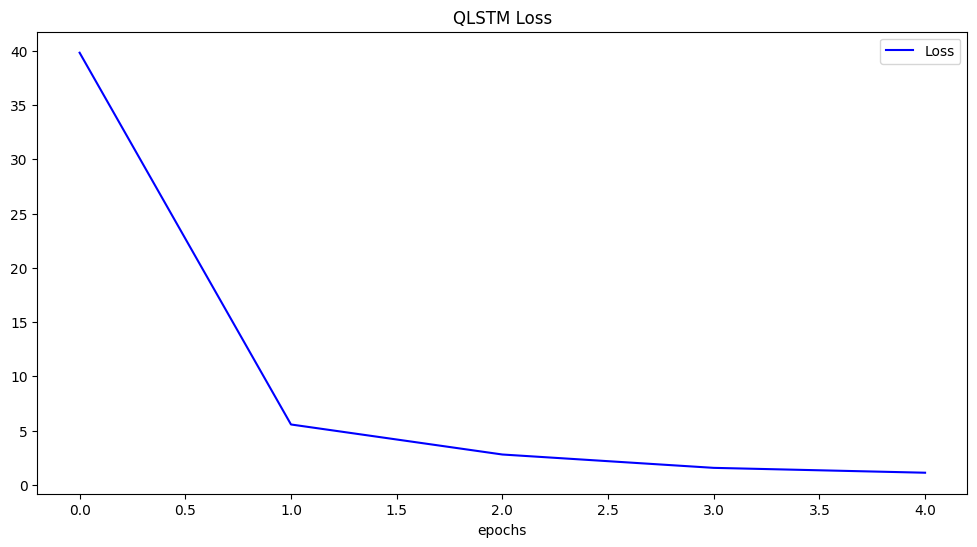

In [24]:
np.savetxt('./SavedModels/Weather/SF/loss/clstm_attn.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [25]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
#print(X_train[0].unsqueeze(0))
#print(y_train[0].unsqueeze(0))

1017
4098
4098


In [26]:
def predict(X,y, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_star = model(X[i].unsqueeze(0),y[i].unsqueeze(0))
            '''if list(y_star.size()) == [1,1]:
                y_star = y_star.tolist()
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star = torch.tensor(y_star)'''
            output = torch.cat((output, y_star), 0)


    return output

In [27]:
pred_y_test = predict(X_test,y_test, modelQ)
print(len(pred_y_test))
print(pred_y_test)

1017
tensor([[ 0.7968],
        [ 0.7955],
        [ 1.2420],
        ...,
        [-1.3728],
        [-1.5672],
        [-1.5693]])


In [28]:
pred_y_train = predict(X_train,y_train, modelQ)
print(len(pred_y_train))
print(pred_y_train)

4098
tensor([[-0.9771],
        [-0.9456],
        [-1.0531],
        ...,
        [ 0.1839],
        [ 0.1834],
        [ 0.0151]])


In [29]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [30]:
print(len(pred_y_train))
print(len(y_train))

4098
4098


In [31]:
pred_y_test

tensor([[ 0.7968],
        [ 0.7955],
        [ 1.2420],
        ...,
        [-1.3728],
        [-1.5672],
        [-1.5693]])

In [32]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [33]:
np.savetxt('./SavedModels/Weather/SF/train/clstm_attn.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/SF/test/clstm_attn.txt',y_test_pred)

Training dataset RMSE:0.20077361906049762


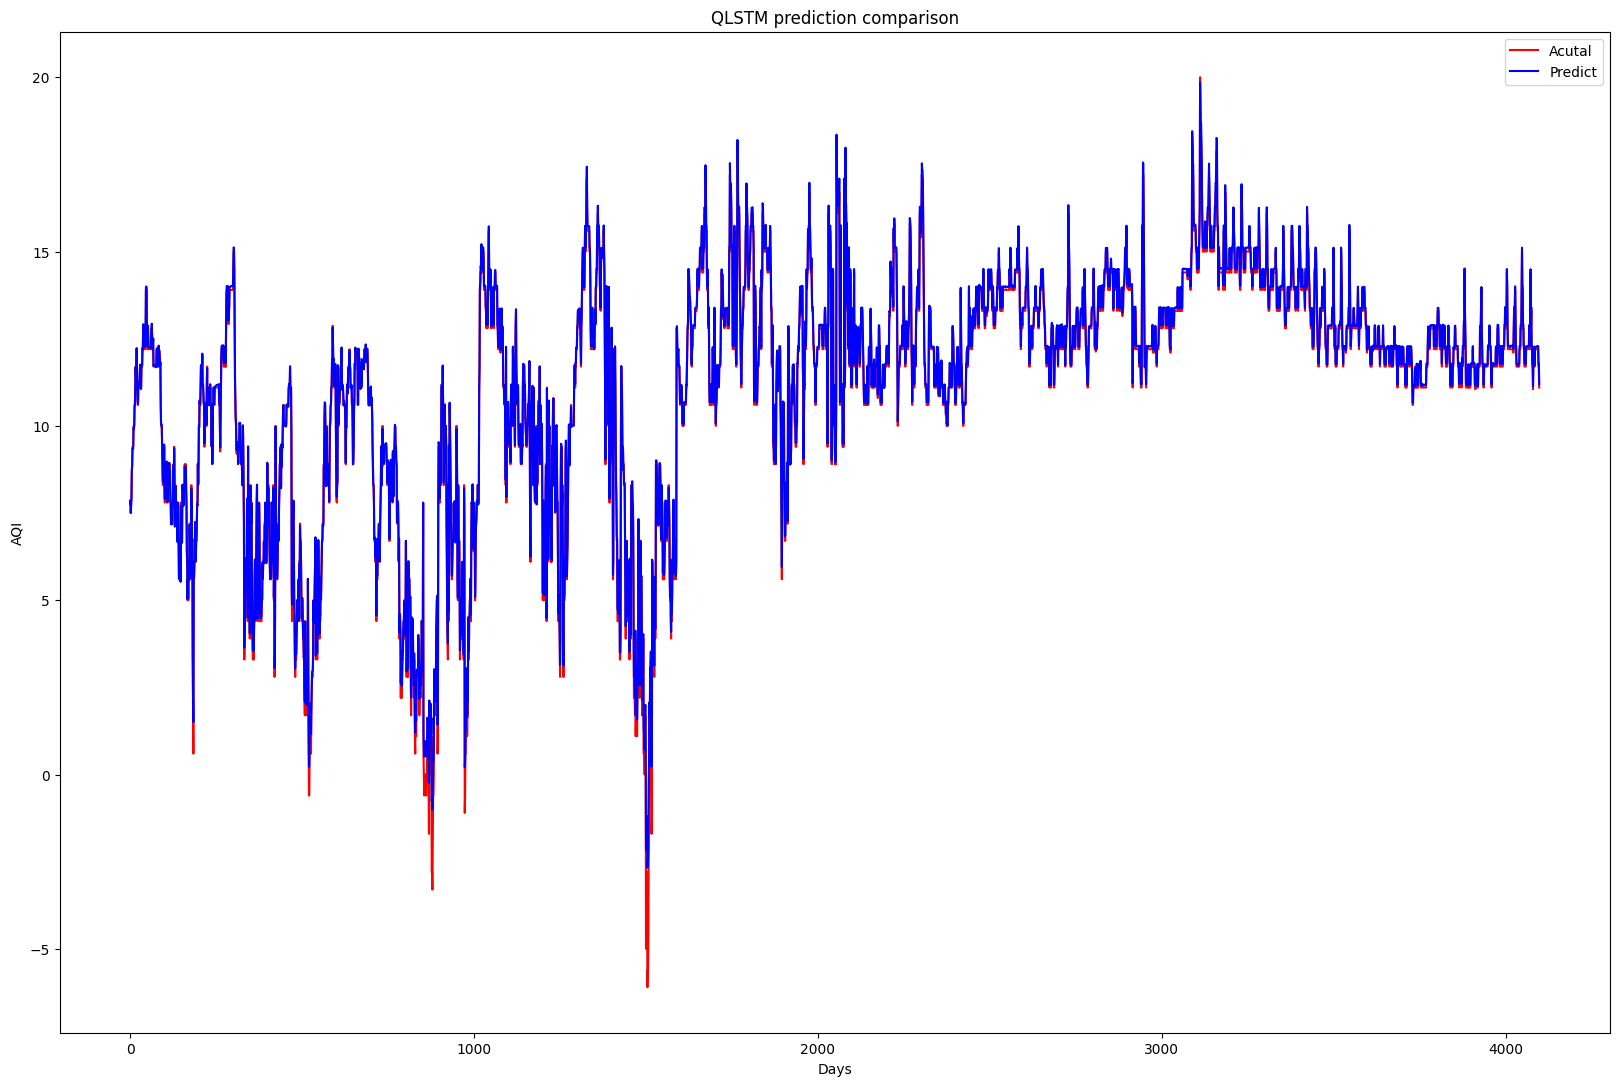

In [34]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:0.0950396081045864


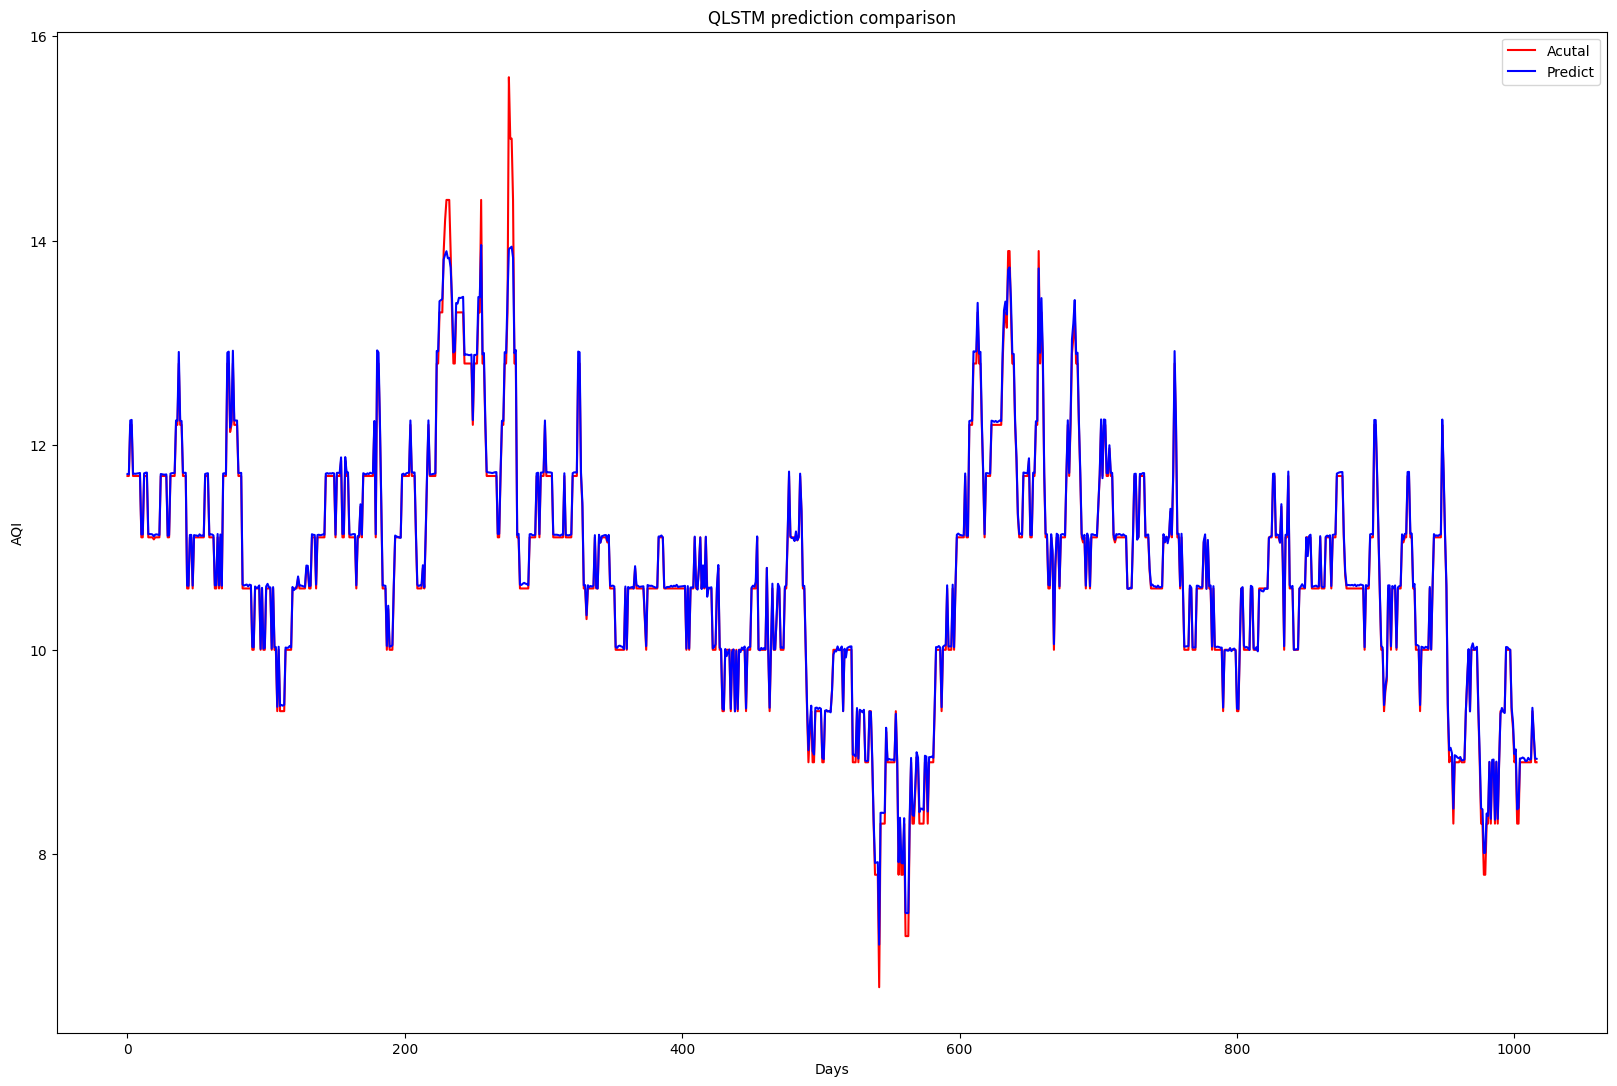

In [35]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [36]:
torch.save(modelQ,'./SavedModels/Weather/SF/model/CLSTM_attn_aqi')